# Import data
## Categories and super-categories

Number of super categories: 28
Number of categories: 60
Number of annotations: 4784
Number of images: 1500
Super category names: {'Aluminium foil': 0, 'Battery': 1, 'Blister pack': 2, 'Bottle': 3, 'Bottle cap': 4, 'Broken glass': 5, 'Can': 6, 'Carton': 7, 'Cup': 8, 'Food waste': 9, 'Glass jar': 10, 'Lid': 11, 'Other plastic': 12, 'Paper': 13, 'Paper bag': 14, 'Plastic bag & wrapper': 15, 'Plastic container': 16, 'Plastic glooves': 17, 'Plastic utensils': 18, 'Pop tab': 19, 'Rope & strings': 20, 'Scrap metal': 21, 'Shoe': 22, 'Squeezable tube': 23, 'Straw': 24, 'Styrofoam piece': 25, 'Unlabeled litter': 26, 'Cigarette': 27}
Super Categories number of annotations{1: 62, 2: 2, 3: 7, 4: 439, 5: 289, 6: 138, 7: 273, 8: 251, 9: 192, 10: 8, 11: 6, 12: 87, 13: 273, 14: 148, 15: 27, 16: 850, 17: 72, 18: 4, 19: 37, 20: 99, 21: 29, 22: 20, 23: 7, 24: 7, 25: 161, 26: 112, 27: 517, 28: 667}


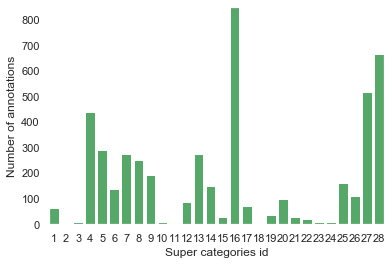

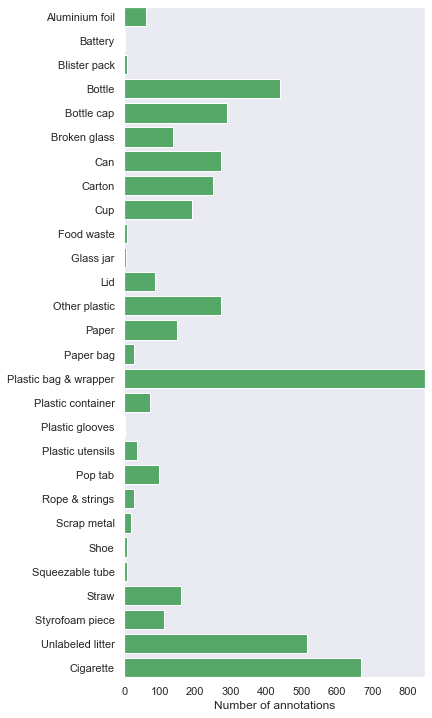

In [2]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os.path
import matplotlib
# root_path = "./drive/My Drive/darknet"
# dataset_path = root_path + '/data'
# %matplotlib
anns_file_path = "annotations.json"

cat_to_ann = dict()
for key in range(1, 29):
    cat_to_ann[key] = 0

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_last_name = categories[0]['supercategory']
super_cat_ids = {super_cat_last_name: 0}
nr_super_cats = 1
cat_to_super_cat = {}

img_ids = dict()
# Get id for image from path 
for img in imgs:
    img_ids[img['file_name']] = img['id']


for i, cat_it in enumerate(categories):
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # print("Index: {}, cat: {}, supercat: {}".format(i, cat_it['name'], cat_it['supercategory']))
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1    
    cat_to_super_cat[i] = nr_super_cats - 1


for ann in dataset['annotations']:
    supercat_id = cat_to_super_cat[ann['category_id']]
    cat_to_ann[supercat_id+1] += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)
# print('Super category names: ' + str(super_cat_names))
print('Super category names: ' + str(super_cat_ids))
print('Super Categories number of annotations' + str(cat_to_ann))

fig, ax = plt.subplots(1)

ax.set_facecolor('white')
ax.autoscale(tight=True)
plt.ylabel ('Number of annotations')
plt.xlabel ('Super categories id')
ax.grid(False)

ax.bar(cat_to_ann.keys(), cat_to_ann.values(), color='g', tick_label=list(cat_to_ann.keys()))


fig, ax = plt.subplots(figsize=(5,10))
y_pos = np.arange(len(super_cat_ids.keys()))
# ax.grid(False)
ax.grid(False)
fig.tight_layout()
ax.set_yticks(y_pos)
ax.set_yticklabels(list(super_cat_ids.keys()))
ax.invert_yaxis()
plt.xlabel("Number of annotations")
ax.autoscale(enable=True,tight=True) 
ax.barh(y_pos, cat_to_ann.values(),color='g')

plt.show()

# Obtain Image file names

In [0]:
from os import listdir
from os.path import isfile, join, isdir, exists

# Dataset file names
dataset_files = []

dataset_dirs = [f for f in listdir(dataset_path) if isdir(join(dataset_path, f))]
for dir_name in dataset_dirs:
    path = dataset_path + "/" + dir_name
    for f in listdir(path):
        if isfile(join(path, f)) and not f.endswith(".txt"):
            dataset_files.append(dir_name + '/' + f)

dataset_files[:10]

['batch_1/000008.jpg',
 'batch_1/000006.jpg',
 'batch_1/000019.jpg',
 'batch_1/000010.jpg',
 'batch_1/000055.jpg',
 'batch_1/000026.jpg',
 'batch_1/000047.jpg',
 'batch_1/000001.jpg',
 'batch_1/000005.jpg',
 'batch_1/000014.jpg']

# Split data for train and test


In [0]:
from sklearn.model_selection  import train_test_split

file_train = root_path + "/train.txlt"
file_test =  root_path + "/test.txt"

X_train, X_test = train_test_split(dataset_files, test_size=0.2, random_state=0)

with open(file_train,"w") as file_stream:
    for file_name in X_train:
        file_name = "/content" + dataset_path[1:] + "/" + file_name
        file_stream.write(file_name)
        file_stream.write("\n")

with open(file_test,"w") as file_stream:
    for file_name in X_test:
        file_name = "/content" + dataset_path[1:] + "/" + file_name
        file_stream.write(file_name)
        file_stream.write("\n")

# Rectangle coordonates for labels


In [0]:
from PIL import Image, ExifTags
from pycocotools.coco import COCO
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection
import colorsys
import random
import pylab

# Obtain Exif orientation tag code
for orientation in ExifTags.TAGS.keys():
    if ExifTags.TAGS[orientation] == 'Orientation':
        break

# Loads dataset as a coco object
coco = COCO(anns_file_path)

current_img = 1
num_images = len(dataset_files)

for file_path in dataset_files:
    image_filepath = file_path
    text_filepath = dataset_path + '/' + file_path[:-3] + "txt"

    # Find image id
    img_id = img_ids[image_filepath]

    # Show image and corresponding annotations
    if img_id == -1:
        print('Incorrect file name')
    else:

        # Load image        
        I = Image.open(dataset_path + '/' + image_filepath)
        # Load and process image metadata
        if I._getexif():
            exif = dict(I._getexif().items())
            # Rotate portrait and upside down images if necessary
            if orientation in exif:
                if exif[orientation] == 3:  
                    I = I.rotate(180,expand=True)
                if exif[orientation] == 6:
                    I = I.rotate(270,expand=True)
                if exif[orientation] == 8:
                    I = I.rotate(90,expand=True)

        # Get annotation id
        annIds = coco.getAnnIds(imgIds=img_id, catIds=[], iscrowd=None)
        anns_sel = coco.loadAnns(annIds)  

        print("Load image num: {}/{}".format(current_img, num_images))

        # Write coordonates and class name
        with open (text_filepath, "w+") as file_stream:
            for image_info in anns_sel:
                [x, y, w, h] = image_info['bbox']        
            
                # Category id            
                category_id = cat_to_super_cat[image_info["category_id"]]
                
                # Compute centers
                x_center = (x + w / 2) / I.width
                y_center = (y + h / 2) / I.height
                width = w / I.width
                height = h / I.height

                # Write coordonates and class type to file
                line = str(category_id) + " " + str(x_center) + " " + str(y_center) + " " + str(width) + " " + str(height) + "\n"
                file_stream.write(line)
        current_img += 1


# Run darknet

## Run if connection lost

In [0]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [0]:
!pwd
!cp -r ./drive/My\ Drive/darknet/bin/darknet ./darknet
%cd darknet

# Set execution permissions to Darknet
!chmod +x ./darknet

/content
/content/darknet


In [0]:
# move data from Google Drive to VM
import shutil
import os

drive_path = "/content/drive/My Drive/darknet"
root_path = "/content/drive/My Drive/data_train"

train_file = "train.txt"
test_file = "test.txt"

def copy_files(drive_path, root_path, input_file):
    src_path = drive_path + '/' + input_file
    dest_path = root_path + '/' + input_file
    files = []

    # load original data
    with open(src_path) as f:
        files = f.readlines()

    if len(files) == 0:
        return

    with open(dest_path, 'w') as f:
        for line in files:
            img_src = line.strip("\n")
            txt_src = img_src[:-3] + "txt"
            dirname, filename = img_src.split("/")[-2:]
            dirpath = root_path + '/' + dirname
            if not os.path.exists(dirpath):
                print("dir '{}' does not exist, creating...".format(dirname))
                os.mkdir(dirpath)
            img_dest = dirpath + '/' + filename
            txt_dest = img_dest.replace(img_dest[-3:], "txt")
            print("Copying '{}' to '{}'...".format(img_src, img_dest))
            shutil.copy2(img_src, img_dest)
            shutil.copy2(txt_src, txt_dest)
            f.write(img_dest)
            f.write('\n')

copy_files(drive_path, root_path, train_file)
copy_files(drive_path, root_path, test_file)

dir 'augm_1' does not exist, creating...
Copying '/content/drive/My Drive/darknet/data/augm_1/gen_1581.jpg' to '/content/darknet/augm_1/gen_1581.jpg'...
dir 'batch_4' does not exist, creating...
Copying '/content/drive/My Drive/darknet/data/batch_4/000012.JPG' to '/content/darknet/batch_4/000012.JPG'...
Copying '/content/drive/My Drive/darknet/data/augm_1/gen_2029.jpg' to '/content/darknet/augm_1/gen_2029.jpg'...
dir 'augm_3' does not exist, creating...
Copying '/content/drive/My Drive/darknet/data/augm_3/gen_3850.jpg' to '/content/darknet/augm_3/gen_3850.jpg'...
dir 'augm_2' does not exist, creating...
Copying '/content/drive/My Drive/darknet/data/augm_2/gen_2569.jpg' to '/content/darknet/augm_2/gen_2569.jpg'...
dir 'augm_13' does not exist, creating...
Copying '/content/drive/My Drive/darknet/data/augm_13/gen_12745.jpg' to '/content/darknet/augm_13/gen_12745.jpg'...
dir 'augm_9' does not exist, creating...
Copying '/content/drive/My Drive/darknet/data/augm_9/gen_9288.jpg' to '/conten

In [0]:
# !./darknet detector train "/content/drive/My Drive/darknet/taco.data" "/content/drive/My Drive/darknet/cfg/taco-yolov3.cfg" "/content/drive/My Drive/darknet/backup/taco-yolov3_last.weights" -dont_show -map
# start train again
!./darknet detector train "/content/drive/My Drive/darknet/taco.data" "/content/drive/My Drive/darknet/cfg/taco-yolov3.cfg" "/content/drive/My Drive/darknet/weights/darknet53.conv.74" -dont_show -map

# Resize images(Not used)


In [0]:
import cv2

for file_path in dataset_files[:2]:
    file_path = dataset_path + file_path
    print(file_path)
    img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
     
    print('Original Dimensions : ',img.shape)
 
    scale_percent = 70 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
 
    print('Resized Dimensions : ',resized.shape)

    plt.imshow(resized)
